In [2]:
import os,sys,pickle
import astrophot as ap
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

import morph
from morph import image_moments
from morph import gaussian_kernel
from morph import make_segmap
import sep

sep.set_extract_pixstack(10000000)

api_key = os.getenv('TNG_API_KEY')


In [1]:
import morph

In [ ]:
universe = 'IllustrisTNG'
simulation = 'TNG50-1'
snapnum = 72
subfindid = 360895
camera = 'v0'
band = 'SUBARU_HSC.I'

virgotng_path = f'/lustre/work/connor.bottrell/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'

if not os.access(img_path,0):
    os.system(f'mkdir -p {img_path}')

img_name = f'{img_path}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'

if not os.access(img_name,0):

    base_url = f'http://www.tng-project.org/api'
    img_url = f'{base_url}/{simulation}/snapshots/{snapnum}/subhalos/{subfindid}/skirt/skirt_images_hsc_realistic_{camera}.fits'
    sys_cmd = f'wget -nc -nv --content-disposition --header="API-Key:{api_key}" "{img_url}" -P {img_path}'

    print(sys_cmd)
    os.system(sys_cmd)

# image data downloaded from TNG
target_hdul = fits.open(img_name,mode='readonly')

target_data = target_hdul[f'{band}'].data
target_variance = target_hdul[f'{band} VARIANCE'].data
target_psf = target_hdul[f'{band} PSF'].data
target_bitmsk = target_hdul[f'{band} MASK'].data
target_hdr = target_hdul[f'{band}'].header

pixel_scale = target_hdr['FOVARC']/target_hdr['NAXIS1']
print(pixel_scale)
zeropoint = 22.5 # zeropoint for AB nanomaggies
wcs = WCS(target_hdr)

# Create segmentation map 

filter_kernel = gaussian_kernel(3.,(7,7))
coords = tuple(wcs.wcs_world2pix([[target_hdr['RA'],target_hdr['DEC']]],0)[0].astype(int))
detect_thresh = 1.0
sep_flag = 0
while True:
    obj,segmap = sep.extract(
        target_data.byteswap().newbyteorder(), 
        thresh=detect_thresh, err=np.sqrt(target_variance),
        mask=None, minarea=20, filter_kernel=filter_kernel,
        filter_type='matched', deblend_nthresh=32, 
        deblend_cont=0.001, clean=True, clean_param=1.0, 
        segmentation_map=True)
    pflag = segmap[coords]
    if detect_thresh>5:
        sep_flag = 1
    if pflag==0:
        break
    elif (pflag in segmap[0,:]) or (pflag in segmap[:,0]) or (pflag in segmap[-1,:]) or (pflag in segmap[:,-1]):
        detect_thresh+=0.5
    elif np.sum(segmap==pflag) < 0.8*target_data.size:
        moments = image_moments(target_data,segmap,pflag,plot=False)
        break
    else:
        detect_thresh+=0.5 

    if pflag==0:
        continue

sky_noise = np.std(target_data[segmap==0])
windows = ap.utils.initialize.windows_from_segmentation_map(segmap)

geff = 55000
target_variance[segmap==pflag] += np.abs(target_data[segmap==pflag])/geff
window = windows[pflag]
print(windows[pflag])
print(target_hdr['APMAG'])
mask = np.logical_and(segmap!=pflag,segmap!=0)

# Create a target object with specified pixelscale and zeropoint
target = ap.image.Target_Image(
    data = np.array(target_data,dtype=np.float64), 
    pixelscale = pixel_scale, 
    zeropoint = zeropoint, 
    variance = np.array(target_variance,dtype=np.float64),
    mask = mask,
    psf = np.array(target_psf,dtype=np.float64),
)

# This model now has a target that it will attempt to match
model = ap.models.AstroPhot_Model(
    name = f"{snapnum:03}_{subfindid}_{camera}", 
    model_type = "sersic galaxy model",
    target = target, 
#    window=window,
    psf_mode='full',
    parameters={
            "center": np.array(coords) * pixel_scale,
        }
)


model.initialize()
result = ap.fit.LM(model, verbose = 1).fit()

# print(model.parameters)

# The default AstroPhot target plot

# The default AstroPhot target plotting method uses log scaling in bright areas and histogram scaling in faint areas
fig,axarr = plt.subplots(1,4,figsize = (20,5))
fig.subplots_adjust(hspace=0,wspace=0)
for ax in axarr.flat:
    ax.tick_params(left=False, labelleft=False,
                   bottom=False, labelbottom=False) 
    
ax_params = {'vmin':16,'vmax':28,'origin':'lower','cmap':'bone','aspect':'auto','interpolation':'None'}

model_data = np.array(model.evaluate_model(np.zeros_like(target_data)))
print(model_data.shape)

from matplotlib.patches import Rectangle
wx,wy = window[0][0],window[1][0]
dx,dy = window[0][1] - window[0][0], window[1][1] - window[1][0]

print(22.5-2.5*np.log10(np.sum(model_data)))
print(22.5-2.5*np.log10(np.sum(target_data[segmap==pflag])))

ax = axarr[0]
ax.imshow(22.5-2.5*np.log10(target_data/pixel_scale**2),**ax_params)
ax = axarr[1]
ax.imshow(22.5-2.5*np.log10(target.data/pixel_scale**2),**ax_params)
ax.add_patch(Rectangle((wx,wy),dx,dy,fill=False))
ax = axarr[2]
ax.imshow(22.5-2.5*np.log10(model_data/pixel_scale**2),**ax_params)
ax.add_patch(Rectangle((wx,wy),dx,dy,fill=False))
ax = axarr[3]
residual = target_data-model_data
residual[mask]=0
ax.imshow(residual,origin='lower',cmap='PiYG',aspect='auto',
          interpolation='None',vmin=-3*sky_noise,vmax=3*sky_noise)
ax.add_patch(Rectangle((wx,wy),dx,dy,fill=False))

fig.savefig('astrophot_hsc.jpg',dpi=256,bbox_inches='tight')


In [ ]:
import os,sys,pickle
import astrophot as ap
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15

import morph
import importlib
importlib.reload(morph)

import sep
sep.set_extract_pixstack(10000000)
api_key = os.getenv('TNG_API_KEY')

universe = 'IllustrisTNG'
simulation = 'TNG50-1'
snapnum = 72 # 91
subfindid = 360895 # 391507
camera = 'v3'

bands = ['G','R','I','Z','Y']
nbands = len(bands)

virgotng_path = f'/Users/cbottrell/Projects/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'
if not os.access(img_path,0): os.system(f'mkdir -p {img_path}')

# Download image from TNG database
img_name = morph.get_skirt_image(universe, simulation, snapnum, subfindid, camera, img_path, api_key)

# Image data downloaded from TNG
target_hdul = fits.open(img_name,mode='readonly')
target_hdr = target_hdul['SUBARU_HSC.I'].header
pixel_scale = target_hdr['FOVARC']/target_hdr['NAXIS1']
redshift = target_hdr['REDSHIFT']
zeropoint = 22.5 # zeropoint for AB nanomaggies
wcs = WCS(target_hdr)

# Create super band comprising data from all bands for segmentation/masking.
super_data = np.zeros((target_hdr['NAXIS1'],target_hdr['NAXIS2']))
super_variance = np.zeros_like(super_data)
for band in bands:
    super_data += target_hdul[f'SUBARU_HSC.{band}'].data/len(bands)
    super_variance += target_hdul[f'SUBARU_HSC.{band} VARIANCE'].data/len(bands)**2

# Get coordinates of image center (this is used to identify the target in the segmap).
coords = tuple(wcs.wcs_world2pix([[target_hdr['RA'],target_hdr['DEC']]],0)[0].astype(int))

# Create segmap, find target flag in segmap, compute moments of target.
segmap, moments, pflag, sep_flag = morph.make_segmap(
    super_data, super_variance, coords)   

# Pixels allocated to the primary target and secondary (non-sky) source pixels.
pri_mask = (segmap==pflag)
sec_mask = (segmap!=pflag) & (segmap!=0)

# Effective gain averaged over 1000 final depth patches in each band.
with open('catalogues/HSC_geff.pkl','rb') as f:
    Geff = pickle.load(f)

# Calculate morphological parameters in all bands using superband segmap.
for band in ['I',]:

    # Band-specific data, variance, and point-spread function.
    target_data = target_hdul[f'SUBARU_HSC.{band}'].data
    target_variance = target_hdul[f'SUBARU_HSC.{band} VARIANCE'].data
    target_psf = target_hdul[f'SUBARU_HSC.{band} PSF'].data

    # Add galaxy shot variance using average effective gain in each band.
    target_variance[pri_mask] += np.abs(target_data[pri_mask])/Geff[band]
    
    # Compute new moments for each band using superband segmentation
    moments = morph.image_moments(target_data, segmap, pflag)
    
    # Some statistics for source and background
    skyMean = np.nanmean(target_data[segmap==0])
    skyMedian = np.nanmedian(target_data[segmap==0])
    skySigma = np.nanstd(target_data[segmap==0])
    nPixSky = int(np.nansum(segmap==0))
    nPixGalaxy = int(np.nansum(pri_mask))

    # Create a target object with specified pixelscale and zeropoint.
    target = ap.image.Target_Image(
        data = np.array(target_data, dtype=np.float64), 
        pixelscale = pixel_scale, zeropoint = zeropoint, 
        variance = np.array(target_variance, dtype=np.float64), 
        mask = sec_mask, psf = np.array(target_psf, dtype=np.float64),
    )

    # This model now has a target that it will attempt to match.
    model = ap.models.AstroPhot_Model(
        name = f"{snapnum:03}_{subfindid}_{camera}", 
        model_type = "sersic galaxy model", target = target, # window=window,
        psf_mode='full', parameters={"center": np.array(coords) * pixel_scale,}
    )
    model.initialize()
    result = ap.fit.LM(model, verbose = 1).fit()
    
    print(model.parameters)

    model_data = np.array(model.evaluate_model(np.zeros_like(target_data)))
    residual_data = target_data-model_data
    residual_data[sec_mask]=0

    npmorph = morph.nonparametric(
        data = target_data, variance = target_variance, 
        segmentation = segmap, model = model_data, 
        residual = residual_data, primary_mask = pri_mask,
        secondary_mask = sec_mask, moments = moments, psf = target_psf,
        pixel_scale = pixel_scale, redshift = redshift, cosmology = Planck15)
    
    npmorph.rmax_circle

fig,axarr = plt.subplots(1,4,figsize=(20,5))
fig.subplots_adjust(hspace=0,wspace=0)
for ax in axarr.flat:
    ax.tick_params(left=False, labelleft=False,
                   bottom=False, labelbottom=False) 
ax_params = {'vmin':16,'vmax':26,'origin':'lower','cmap':'bone',
             'aspect':'auto','interpolation':'None'}
ax = axarr[0]
ax.imshow(22.5-2.5*np.log10(target_data/pixel_scale**2),**ax_params)
ax = axarr[1]
ax.imshow(22.5-2.5*np.log10(target.data/pixel_scale**2),**ax_params)
ax = axarr[2]
ax.imshow(22.5-2.5*np.log10(model_data/pixel_scale**2),**ax_params)
ax = axarr[3]

residual_data[sec_mask]=0
ax.imshow(residual_data/skySigma,origin='lower',cmap='PiYG',aspect='auto',
          interpolation='None',vmin=-3,vmax=3)



In [6]:
print(result.chi2min())

3.5067186962497225


/var/folders/2r/j4z3cyvd2kxbf_h9p9_p_k380000gn/T/ipykernel_84072/2974313107.py:21: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(target_data),origin='lower')


36.46458718456541


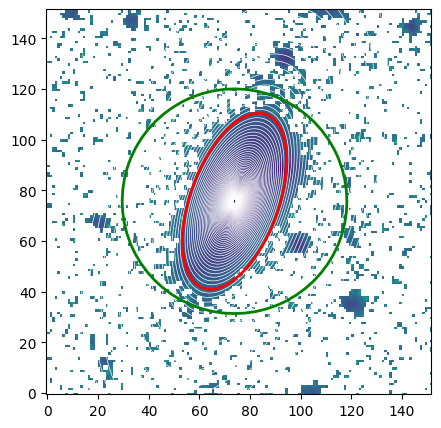

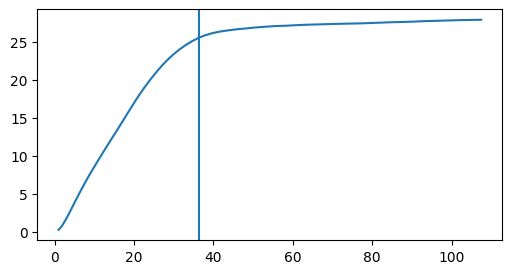

In [3]:
import photutils

# Compute petrosian radii (circular / elliptical)

# # Moments computed specifically for target data (not super band)
# moments = morph.image_moments(target_data,segmap,pflag,plot=True)

rp_ellipse, r_list, flux_arr = morph.petrosian_radius(
    target_data, target_variance, segmap, moments,
    pri_mask, sec_mask, elliptical=True)

rp_circle, r_list_circ, flux_arr_circ = morph.petrosian_radius(
    target_data, target_variance, segmap, moments,
    pri_mask, sec_mask, elliptical=False)

# Plotting

from matplotlib.patches import Ellipse

fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(22.5-2.5*np.log10(target_data),origin='lower')

for i in range(len(r_list)):

    ellipse = Ellipse(
    (moments['X'],moments['Y']), width=2*r_list[i], 
        height=2*r_list[i]*moments['q'], facecolor='None', edgecolor='white',
        linewidth=0.5, angle = moments['phi_deg']+90)
    ellipse.set_transform(ax.transData)
    ax.add_patch(ellipse)
    
ellipse = Ellipse(
    (moments['X'],moments['Y']), width=2*rp_ellipse, height=2*rp_ellipse*moments['q'],
    facecolor='None', edgecolor='red', linewidth=2, 
    angle = moments['phi_deg']+90)
ellipse.set_transform(ax.transData)
ax.add_patch(ellipse)

# ap = photutils.aperture.CircularAperture(
#     (moments['X'],moments['Y']),rp_circle)
# ap.plot(ax, origin=(0,0))
# ap = photutils.aperture.EllipticalAperture(
#     (moments['X'],moments['Y']),a=rp_ellipse,b=rp_ellipse*moments['q'],
#     theta=moments['phi_deg']*np.pi/180+np.pi/2)
# ap.plot(ax, origin=(0,0))

ellipse = Ellipse(
    (moments['X'],moments['Y']), width=1.5*2*rp_circle, height=1.5*2*rp_circle,
    facecolor='None', edgecolor='green', linewidth=2, 
    angle = moments['phi_deg']+90)
ellipse.set_transform(ax.transData)
ax.add_patch(ellipse)

fig,ax = plt.subplots(figsize=(6,3))
ax.plot(r_list,flux_arr)
ax.axvline(rp_ellipse)

print(rp_ellipse)


0.17428134717942959

/home/connor.bottrell/.conda/envs/astrophot/lib/python3.12/site-packages/astrophot/utils/conversions/units.py:17: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + zeropoint + 2.5 * np.log10(pixel_area)


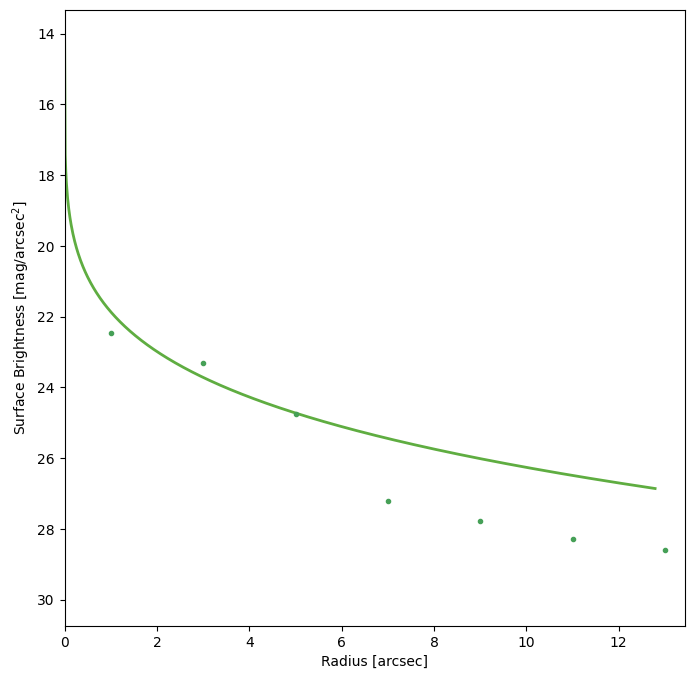

In [5]:
fig, ax = plt.subplots(figsize = (8,8))
ap.plots.radial_light_profile(fig, ax, model)
ap.plots.radial_median_profile(fig, ax, model)
plt.show()

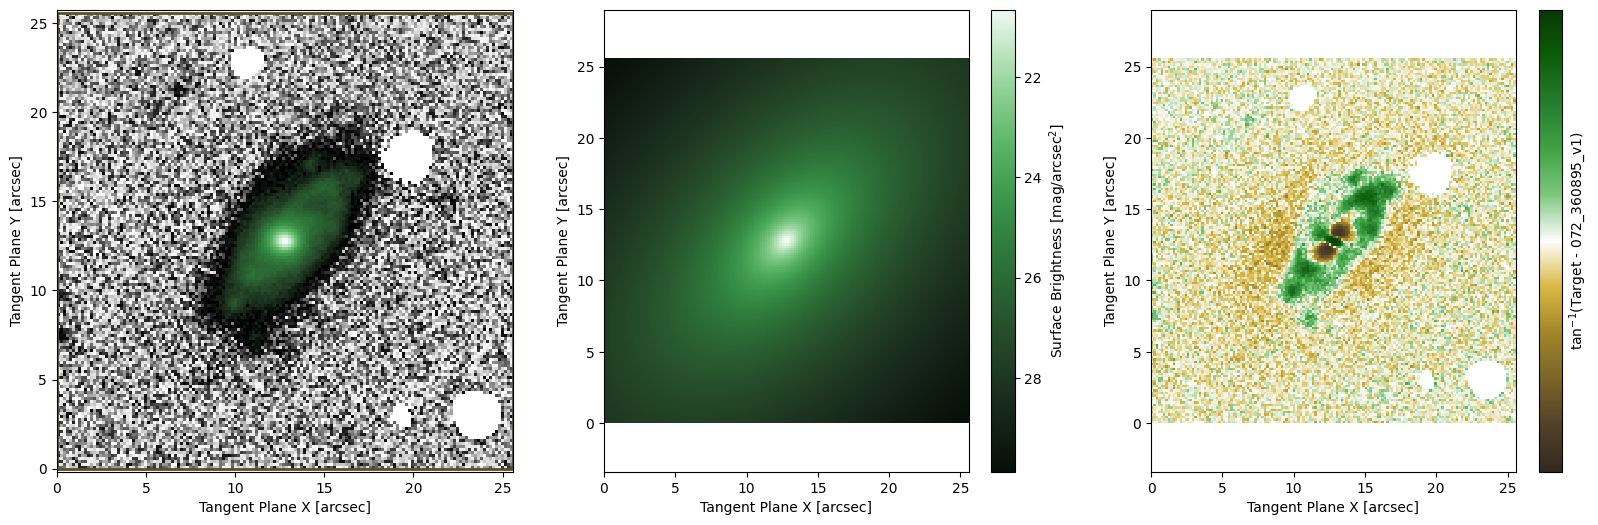

In [4]:
fig, axarr = plt.subplots(1, 3, figsize = (20,6))
ap.plots.target_image(fig,axarr[0],target)
ap.plots.model_window(fig,axarr[0],model)
ap.plots.model_image(fig, axarr[1],model)
ap.plots.residual_image(fig, axarr[2], model)
plt.show()

/tmp/ipykernel_158003/1970401691.py:9: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(target_data/pixel_scale**2),**ax_params)
/tmp/ipykernel_158003/1970401691.py:11: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(target.data/pixel_scale**2),**ax_params)


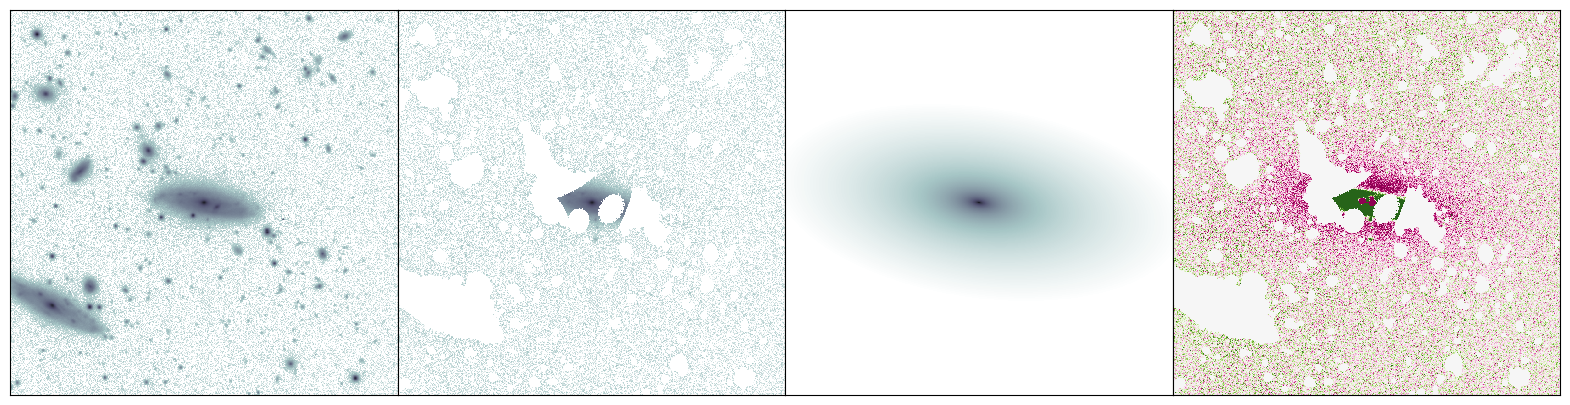

In [3]:
fig,axarr = plt.subplots(1,4,figsize=(20,5))
fig.subplots_adjust(hspace=0,wspace=0)
for ax in axarr.flat:
    ax.tick_params(left=False, labelleft=False,
                   bottom=False, labelbottom=False) 
ax_params = {'vmin':16,'vmax':28,'origin':'lower','cmap':'bone',
             'aspect':'auto','interpolation':'None'}
ax = axarr[0]
ax.imshow(22.5-2.5*np.log10(target_data/pixel_scale**2),**ax_params)
ax = axarr[1]
ax.imshow(22.5-2.5*np.log10(target.data/pixel_scale**2),**ax_params)
ax = axarr[2]
ax.imshow(22.5-2.5*np.log10(model_data/pixel_scale**2),**ax_params)
ax = axarr[3]

residual_data[sec_mask]=0
ax.imshow(residual_data/skySigma,origin='lower',cmap='PiYG',aspect='auto',
          interpolation='None',vmin=-3,vmax=3)


In [6]:
import pickle
with open('catalogues/HSC_geff.pkl', 'rb') as f:
    geffs = pickle.load(f)

print(geffs)

{'G': 67806.57281769325, 'R': 66180.63095135443, 'I': 63900.00912402326, 'Z': 39070.83363789063, 'Y': 31270.12617692004}


In [14]:
model.parameters

072_360895_v1 (id-47236540234736, branch node):
  center (id-47236546102768): [12.70631506824555, 12.773575620420626] +- [0.1, 0.1] [arcsec]
  q (id-47236546440000): 0.5514896445230317 +- 0.03 [b/a], limits: (0.0, 1.0)
  PA (id-47236546440480): 2.377973906546364 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
  n (id-47236546440288): 4.583425392826284 +- 0.05 [none], limits: (0.36, 8.0)
  Re (id-47236564233792): 4.218966282844116 +- 0.47548069851164826 [arcsec], limits: (0.0, None)
  Ie (id-47236565534192): -0.7888278007267505 +- 0.13768759759798316 [log10(flux/arcsec^2)]

In [6]:
2.377*180/np.pi

136.19206790259668

In [5]:
import pickle

# Effective gain averaged over 1000 final depth patches in each band.
with open('catalogues/HSC_geff.pkl','rb') as f:
    Geff = pickle.load(f)

Geff

{'G': 67806.57281769325,
 'R': 66180.63095135443,
 'I': 63900.00912402326,
 'Z': 39070.83363789063,
 'Y': 31270.12617692004}

Deblending:   0%|          | 0/293 [00:00<?, ?it/s]

/tmp/ipykernel_4188/136796784.py:77: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(super_data/pixel_scale**2),**ax_params)
/tmp/ipykernel_4188/136796784.py:83: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(masked_data/pixel_scale**2),**ax_params)
/tmp/ipykernel_4188/136796784.py:100: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(super_data/pixel_scale**2),**ax_params)
/tmp/ipykernel_4188/136796784.py:106: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(masked_data/pixel_scale**2),**ax_params)


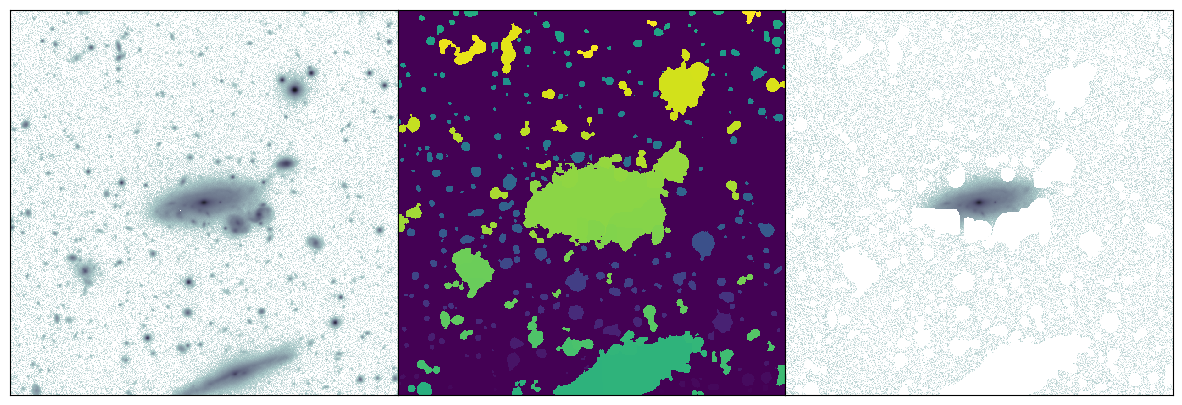

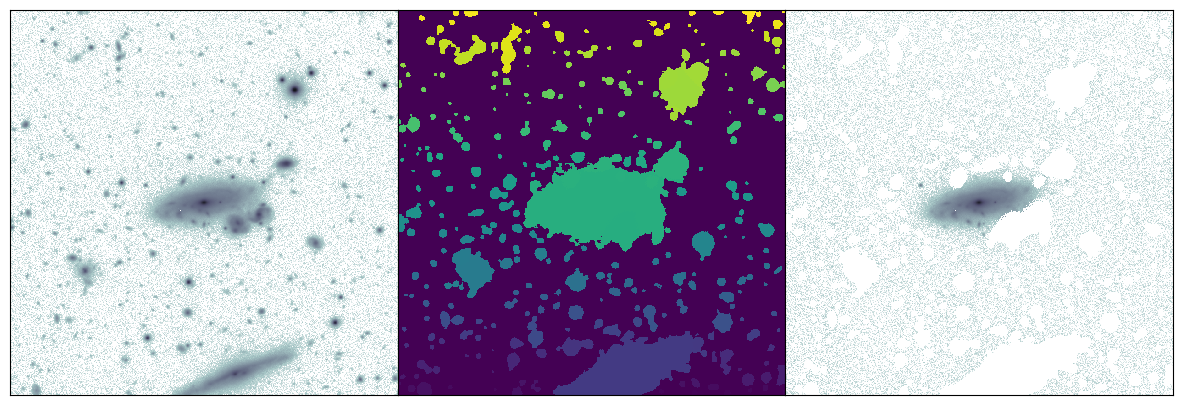

In [23]:
import os,sys,pickle
import astrophot as ap
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import photutils as pt

from astropy.convolution import convolve

import morph
import importlib
importlib.reload(morph)
import sep
sep.set_extract_pixstack(10000000)
api_key = os.getenv('TNG_API_KEY')

universe = 'IllustrisTNG'
simulation = 'TNG50-1'
snapnum = 91
subfindid = 391507
camera = 'v2'

bands = ['G','R','I','Z','Y']
nbands = len(bands)

virgotng_path = f'/lustre/work/connor.bottrell/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'

# Download image from TNG database
img_name = morph.get_skirt_image(universe, simulation, snapnum, subfindid, camera, img_path)

# Image data downloaded from TNG
target_hdul = fits.open(img_name,mode='readonly')
target_hdr = target_hdul['SUBARU_HSC.I'].header
pixel_scale = target_hdr['FOVARC']/target_hdr['NAXIS1']
zeropoint = 22.5 # zeropoint for AB nanomaggies
wcs = WCS(target_hdr)

# Create super band comprising data from all bands for segmentation/masking.
super_data = np.zeros((target_hdr['NAXIS1'],target_hdr['NAXIS2']))
super_variance = np.zeros_like(super_data)
for band in bands:
    super_data += target_hdul[f'SUBARU_HSC.{band}'].data/len(bands)
    super_variance += target_hdul[f'SUBARU_HSC.{band} VARIANCE'].data/len(bands)**2

# Get coordinates of image center (this is used to identify the target in the segmap).
coords = tuple(wcs.wcs_world2pix([[target_hdr['RA'],target_hdr['DEC']]],0)[0].astype(int))

kernel = morph.gaussian_kernel(5,(11,11))

segmap = pt.segmentation.detect_sources(
    data = convolve(super_data, kernel, boundary='fill'), 
    threshold = 0.5*np.sqrt(super_variance),
    npixels = 5, connectivity = 4,)

segmap = pt.segmentation.deblend_sources(
    data = convolve(super_data, kernel, boundary='fill'), 
    segment_img = segmap, npixels = 5, nlevels=32, 
    contrast=0.00005, mode='sinh', connectivity=4).data

pflag = segmap[coords]
primary_mask = (segmap == pflag)
secondary_mask = (segmap != pflag) & (segmap != 0) 


fig,axarr = plt.subplots(1,3,figsize=(15,5))
fig.subplots_adjust(hspace=0,wspace=0)
for ax in axarr.flat:
    ax.tick_params(left=False, labelleft=False,
                   bottom=False, labelbottom=False) 
ax_params = {'vmin':16,'vmax':28,'origin':'lower','cmap':'bone',
             'aspect':'auto','interpolation':'None'}
ax = axarr[0]
ax.imshow(22.5-2.5*np.log10(super_data/pixel_scale**2),**ax_params)
ax = axarr[1]
ax.imshow(segmap,origin='lower',interpolation='None',aspect='auto')
ax = axarr[2]
masked_data = np.ones_like(super_data)*super_data
masked_data[secondary_mask]=np.nan
ax.imshow(22.5-2.5*np.log10(masked_data/pixel_scale**2),**ax_params)


segmap, moments, pflag, sep_flag = morph.make_segmap(
    super_data, super_variance, coords)  
pflag = segmap[coords]
primary_mask = (segmap == pflag)
secondary_mask = (segmap != pflag) & (segmap != 0) 

fig,axarr = plt.subplots(1,3,figsize=(15,5))
fig.subplots_adjust(hspace=0,wspace=0)
for ax in axarr.flat:
    ax.tick_params(left=False, labelleft=False,
                   bottom=False, labelbottom=False) 
ax_params = {'vmin':16,'vmax':28,'origin':'lower','cmap':'bone',
             'aspect':'auto','interpolation':'None'}
ax = axarr[0]
ax.imshow(22.5-2.5*np.log10(super_data/pixel_scale**2),**ax_params)
ax = axarr[1]
ax.imshow(segmap,origin='lower',interpolation='None',aspect='auto')
ax = axarr[2]
masked_data = np.ones_like(super_data)*super_data
masked_data[secondary_mask]=np.nan
ax.imshow(22.5-2.5*np.log10(masked_data/pixel_scale**2),**ax_params)

In [39]:
import numpy as np

def create_circular_tophat_kernel(size):
    if size % 2 == 0:
        raise ValueError("Size must be an odd number")

    # Create an empty kernel
    kernel = np.zeros((size, size))

    # Calculate the center index
    center = size // 2

    # Create a grid of indices
    x_indices, y_indices = np.indices((size, size))

    # Calculate the distance of each point from the center
    distances = np.sqrt((x_indices - center)**2 + (y_indices - center)**2)

    # Set elements within the circular region to 1
    kernel[distances <= center] = 1

    return kernel

# Example usage:
kernel_size = 11  # Size of the kernel (odd number)
circular_tophat_kernel = create_circular_tophat_kernel(kernel_size)
print("Circular Tophat Kernel:")
print(circular_tophat_kernel)

Circular Tophat Kernel:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [62]:
class SimpleCalculator:
    def __init__(self, x):
        self.x = x
        print(self.x)
        print("Initializing SimpleCalculator")

    def add(self, x, y):
        return x + y

# Creating an instance of the SimpleCalculator class
calculator = SimpleCalculator(x = 2,)

# Using the add method of the SimpleCalculator class
result = calculator.add(5, 3)
print("Result of addition:", result)


2
Initializing SimpleCalculator
Result of addition: 8


In [72]:
464.00*4


1856.0